<a href="https://colab.research.google.com/github/engelberger/ColabDesign/blob/main/af/examples/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2_advanced_v2
aka. **Colab[Design]Fold**, we've come full circle...

WARNING: this is an experimental notebook. For anything serious please use our [colabfold](https://github.com/sokrypton/ColabFold) notebooks.

In [1]:
%%time
#@title setup
unified_memory = False #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap
import colabdesign.af.contrib.extended_ptm as extended_ptm

import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

installing ColabDesign
installing HHsuite
downloading AlphaFold params
CPU times: user 3 s, sys: 281 ms, total: 3.28 s
Wall time: 1min 22s


jobname Cluster10trimerloopsplusbeta_filter_l159_s806527_7e126
length=[219, 159] copies=1
getting paired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:18 remaining: 00:00]


getting unpaired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:47 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


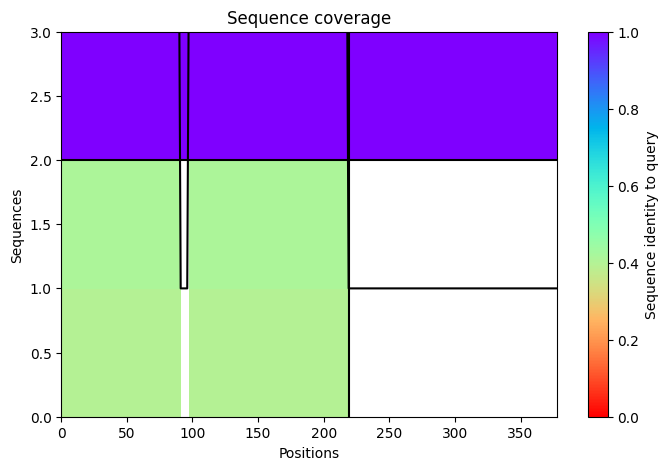

aligning template


Saving Cluster10trimerloopsplusbeta_filter_l159_s806527.pdb to Cluster10trimerloopsplusbeta_filter_l159_s806527.pdb


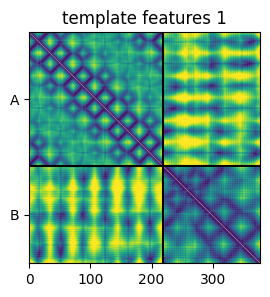

GC 35077


In [19]:
#@title prep_inputs
sequence = "QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:MTEEQKKALEYAISYLLGYLPWFPKVEKVFMERLKKEYGINSWEEYKEFILNSEDPELILEVTLDNFVDAAIETGEVRPPLFYQWLEQVLPYYFYAFRSFGEEVLQKVLDRFVAAWERYMRWMAEHRPDLLSPEQAEASIRDYRVWARMQMPNDPSSLP" #@param {type:"string"}
jobname = "Cluster10trimerloopsplusbeta_filter_l159_s806527" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "custom" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "A,B" #@param {type:"string"}
rm_template_seq = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
do_not_align = False #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [43]:
#@title prep_inputs
sequence = "QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:MTEEQKKALEYAISYLLGYLPWFPKVEKVFMERLKKEYGINSWEEYKEFILNSEDPELILEVTLDNFVDAAIETGEVRPPLFYQWLEQVLPYYFYAFRSFGEEVLQKVLDRFVAAWERYMRWMAEHRPDLLSPEQAEASIRDYRVWARMQMPNDPSSLP" #@param {type:"string"}
jobname = "Cluster10trimerloopsplusbeta_filter_l159_s806527" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90  #@param ["90", "100"] {type:"raw"}
qid = 0  #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False  #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "custom" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""  #@param {type:"string"}
chain = "A,B"  #@param {type:"string"}
rm_template_seq = False  #@param {type:"boolean"}
propagate_to_copies = True  #@param {type:"boolean"}
do_not_align = False  #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
import re
sequence = re.sub("[^A-Z:/()]", "", sequence)
sequence = re.sub("\(", ":(", sequence)
sequence = re.sub("\)", "):", sequence)
sequence = re.sub(":+", ":", sequence)
sequence = re.sub("/+", "/", sequence)
sequence = re.sub("^[:/]+", "", sequence)
sequence = re.sub("[:/]+$", "", sequence)
import re
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"):
    n += 1
  jobname = f"{jobname}_{n}"

print("jobname", jobname)
print(f"length={u_lengths} copies={copies}")

# ============= Additional Logging =============
import os
os.makedirs("template_logs", exist_ok=True)
template_log_path = "template_logs/template_usage.log"
with open(template_log_path, "a") as f:
  f.write(f"\n{'='*50}\n")
  f.write(f"Job: {jobname}\n")
  f.write(f"Sequence length(s): {u_lengths}\n")
  f.write(f"Copies: {copies}\n")
  f.write(f"Template mode: {template_mode}\n")
  f.write(f"Template path: {pdb}\n")
  f.write(f"Template chain(s): {chain}\n")
  if pdb and os.path.exists(pdb):
    size_kb = os.path.getsize(pdb)/1024
    f.write(f" Template file exists: Yes, {size_kb:.2f}KB\n")
  else:
    f.write(f" Template file exists: No (or not specified)\n")
  f.write(f"{'='*50}\n")

# We also print these logs to the console for clarity
print("Template usage logs:")
print(f"- Template mode: {template_mode}")
print(f"- Template path: {pdb}")
print(f"- Template chains: {chain}")
if pdb and os.path.exists(pdb):
  size_kb = os.path.getsize(pdb)/1024
  print(f"  => Template file size: {size_kb:.2f} KB")
else:
  print("  => Template file not found or not specified")

input_opts = {
    "sequence": u_sequences,
    "copies": copies,
    "msa_method": msa_method,
    "pair_mode": pair_mode,
    "do_not_filter": do_not_filter,
    "cov": cov,
    "id": id,
    "template_mode": template_mode,
    "propagate_to_copies": propagate_to_copies
}

def run_mmseqs2_wrapper(*args, **kwargs):
  from colabfold_utils import run_mmseqs2
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(
      u_sequences, jobname,
      mode=pair_mode,
      cov=cov, id=id, qid=qid, max_msa=4096,
      do_not_filter=do_not_filter,
      mmseqs2_fn=run_mmseqs2_wrapper,
      hhfilter_fn=run_hhfilter
  )
elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")
else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  from google.colab import files
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as file_out:
    file_out.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(
      f"hhfilter -qid 0 -id 100 -cov 0 "
      f"-i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m"
    )
  else:
    os.system(
      f"hhfilter -qid {qid} -id {id} -cov {cov} "
      f"-i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m"
    )
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(
      u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m"
    )
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n, seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    with open(f"{jobname}/msa/_env/pdb70.m8","r") as fh:
      for line in fh:
        p = line.rstrip().split()
        M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
        M = int(M)
        if M not in templates:
          templates[M] = []
        if len(templates[M]) < 4:
          print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
          templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb_, chain_ in zip(pdbs, chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(
      pdb_, chain_,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhfilter
    )
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches), 3))
  for n, batch in enumerate(batches):
    plt.subplot(1, len(batches), n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC", gc.collect())


jobname Cluster10trimerloopsplusbeta_filter_l159_s806527_092b6
length=[219, 146, 73, 159] copies=1
Template usage logs:
- Template mode: custom
- Template path: 
- Template chains: A,B
  => Template file not found or not specified
getting paired MSA


COMPLETE: 100%|██████████| 600/600 [elapsed: 00:32 remaining: 00:00]


getting unpaired MSA


RUNNING:   6%|▌         | 35/600 [elapsed: 00:44 remaining: 12:01]


KeyboardInterrupt: 

In [20]:
#@title pre_analysis (optional)
analysis = "none" # @param ["none", "coevolution"]
dpi = 100 # @param ["100", "200", "300"] {type:"raw"}
if analysis == "coevolution":
  coevol = get_coevolution(msa)
  plt.figure(figsize=(5,5), dpi=dpi)
  plt.title("coevolution")
  plt.imshow(coevol)
  plt.axis(False)
  plt.show()

In [21]:
#@title prep_model
#@markdown Model options
model_type = "auto" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
rank_by = "auto" #@param ["auto", "plddt", "ptm"]
debug = False #@param {type:"boolean"}
use_initial_guess = False

#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = True #@param {type:"boolean"}

#@markdown Extended metrics (calculate pairwise ipTM, actifpTM and chain pTM)
calc_extended_ptm = False #@param {type:"boolean"}
if len(Ls) == 1 and copies == 1:
  calc_extended_ptm = False

if calc_extended_ptm:
  debug=True

if model_type == "monomer (ptm)":
  use_multimer = False
  pseudo_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
  pseudo_multimer = False
elif model_type == "pseudo_multimer (v3)":
  use_multimer = True
  pseudo_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
  pseudo_multimer = False
else:
  use_multimer = False
  pseudo_multimer = False

if rank_by == "auto":
  rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:

  # interchain masking determined by dgram
  af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence)
# set msa
af.set_msa(msa, deletion_matrix)

# set chainbreaks
L_prev = 0
for n,l in enumerate(u_sub_lengths * copies):
  for L_i in l[:-1]:
    af._inputs["residue_index"][L_prev+L_i:] += 32
    L_prev += L_i
  L_prev += l[-1]

# set cyclic constraints
i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
if len(i_cyclic) > 0:
  add_cyclic_offset(af,i_cyclic)

running prediction
seed=0 model=model_1_multimer_v3 recycle=0 plddt=0.920 ptm=0.861 i_ptm=0.814 multi=0.823
seed=0 model=model_1_multimer_v3 recycle=1 plddt=0.912 ptm=0.803 i_ptm=0.728 multi=0.743 rmsd_tol=0.392


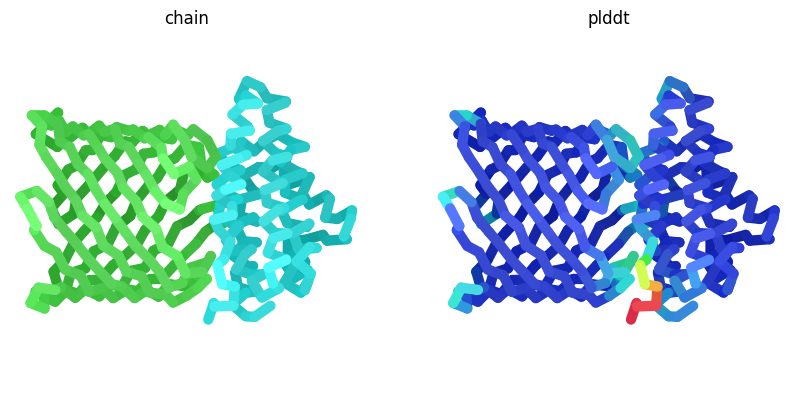

seed=0 model=model_2_multimer_v3 recycle=0 plddt=0.907 ptm=0.780 i_ptm=0.687 multi=0.705
seed=0 model=model_2_multimer_v3 recycle=1 plddt=0.903 ptm=0.791 i_ptm=0.709 multi=0.725 rmsd_tol=0.534
seed=0 model=model_2_multimer_v3 recycle=2 plddt=0.906 ptm=0.794 i_ptm=0.705 multi=0.723 rmsd_tol=0.231


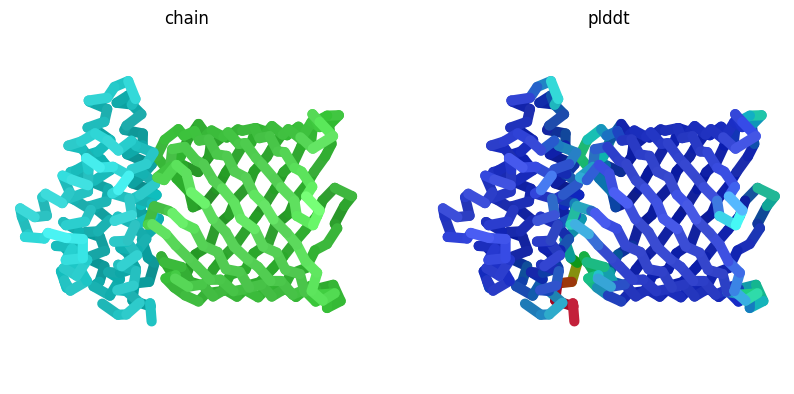

seed=0 model=model_3_multimer_v3 recycle=0 plddt=0.928 ptm=0.857 i_ptm=0.809 multi=0.819
seed=0 model=model_3_multimer_v3 recycle=1 plddt=0.923 ptm=0.826 i_ptm=0.755 multi=0.769 rmsd_tol=0.500


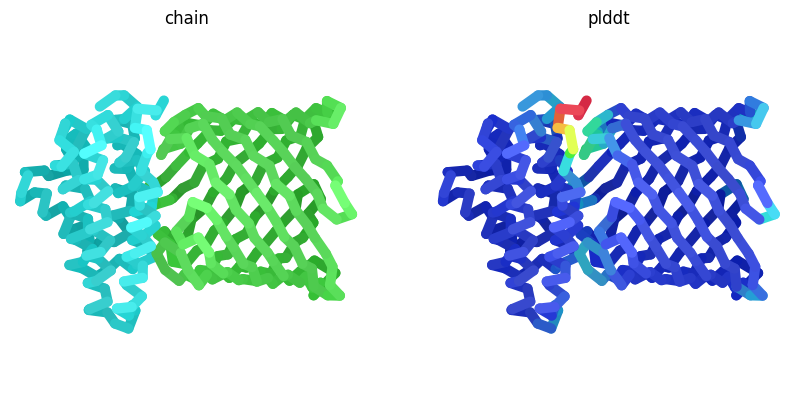

seed=0 model=model_4_multimer_v3 recycle=0 plddt=0.938 ptm=0.853 i_ptm=0.809 multi=0.818
seed=0 model=model_4_multimer_v3 recycle=1 plddt=0.922 ptm=0.820 i_ptm=0.754 multi=0.767 rmsd_tol=0.347


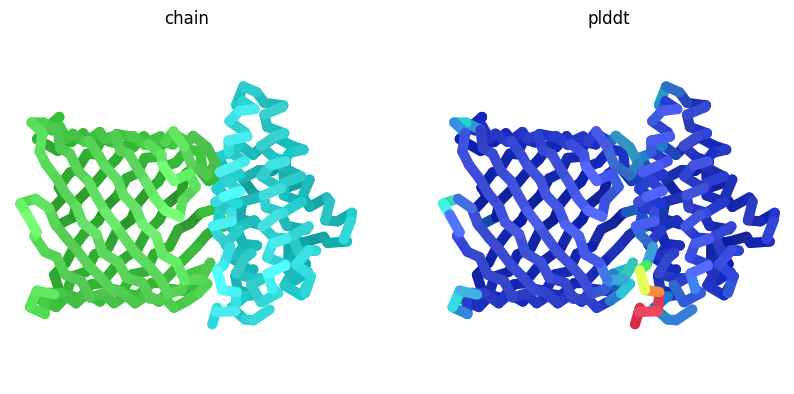

seed=0 model=model_5_multimer_v3 recycle=0 plddt=0.921 ptm=0.815 i_ptm=0.740 multi=0.755
seed=0 model=model_5_multimer_v3 recycle=1 plddt=0.908 ptm=0.796 i_ptm=0.696 multi=0.716 rmsd_tol=0.564
seed=0 model=model_5_multimer_v3 recycle=2 plddt=0.904 ptm=0.791 i_ptm=0.689 multi=0.709 rmsd_tol=0.272


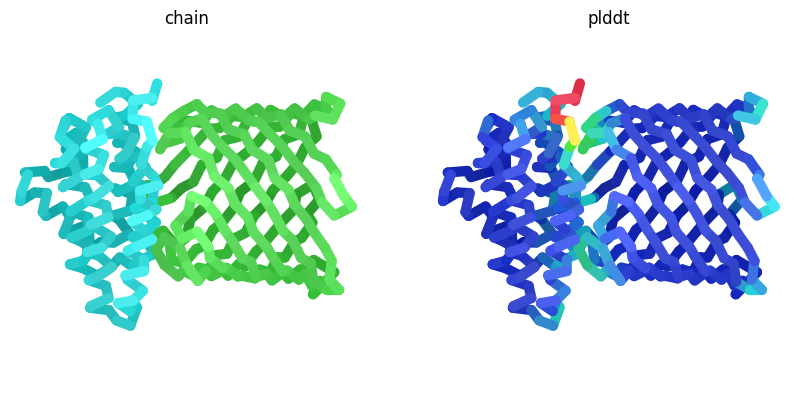

best_tag=model_3_multimer_v3_r1_seed0 seed=0 model=model_3_multimer_v3 recycle=1 plddt=0.923 ptm=0.826 i_ptm=0.755 multi=0.769 rmsd_tol=0.500
GC 49036
CPU times: user 46.8 s, sys: 6.65 s, total: 53.5 s
Wall time: 46 s


In [22]:
%%time
#@title run_alphafold
#@markdown Model options
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = False #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = True #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = True #@param {type:"boolean"}

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          if calc_extended_ptm:
            extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
            info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        if calc_extended_ptm:
          extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
          info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
np.savez_compressed(f"{pdb_path}/best.npz",
                    plddt=aux_best["plddt"].astype(np.float16),
                    pae=aux_best["pae"].astype(np.float16),
                    tag=np.array(info[rank[0]][0]),
                    metrics=np.array(info[rank[0]][1]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    actifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
np.savez_compressed(f"{pdb_path}/all.npz",
                    plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                    pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                    tag=np.array([x[0] for x in info]),
                    metrics=np.array([x[1] for x in info]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    actifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

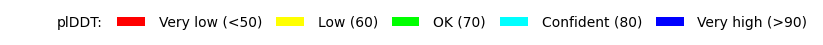

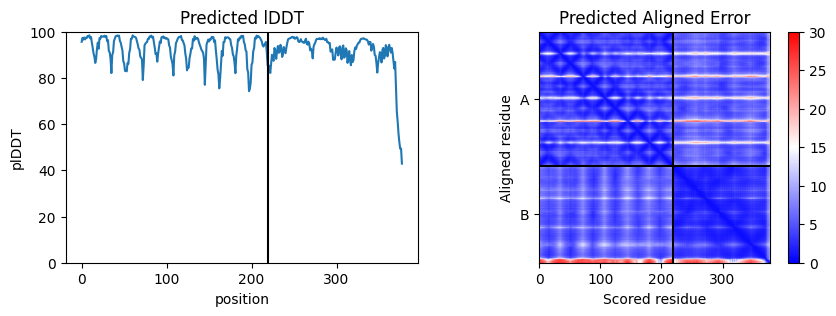

In [23]:
#@title display_best_result (optional) {run: "auto"}
color = "pLDDT" #@param ["pLDDT","chain","rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [ ]:
#@title post_analysis (optional)

analysis = "animate_all_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

IndexError: list index out of range

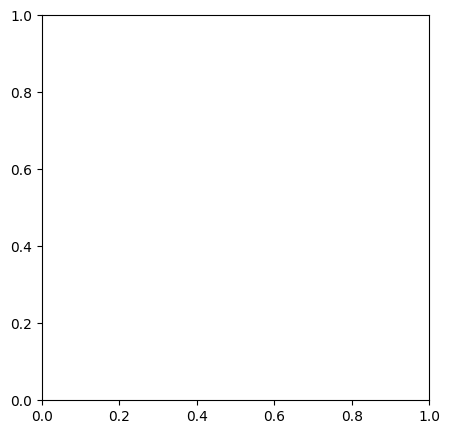

In [15]:
#@title chainwise_and_pairwise_analysis (optional)
if calc_extended_ptm:
  extended_ptm.plot_chain_pairwise_analysis(info, prefix='model_', fig_path=f"{jobname}/chain_pairwise_ptm.png")
  for x in info:
    print(x)

In [18]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
!rm -rf Clust*

Processing jobname: Cluster10trimerloopsplusbeta_filter_l151_s510177
QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ/QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ/QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ:MGWAELMARYLALPPEEGLRALLADVGGQVEVVLAAVRRLIKLKGESPSLRAQEAFAEDFLASAEAAFEAILAGEPGASSRLYIRMQQLIELAQYLWYLVSKEFPEETELQARLAATVGELQVLTQVFGELAARARLAAAARTDPEAARRL

Template information:
- Template mode: custom
- Template path: ./templates/Cluster10trimerloopsplusbeta_filter_l151_s510177.pdb
- Template chains: A,B
u_sequences: ['QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ', 'QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQQIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ', 'QIVGTANTQGNRQSPSA

COMPLETE: 100%|██████████| 600/600 [elapsed: 00:01 remaining: 00:00]


getting unpaired MSA


COMPLETE: 100%|██████████| 600/600 [elapsed: 00:01 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


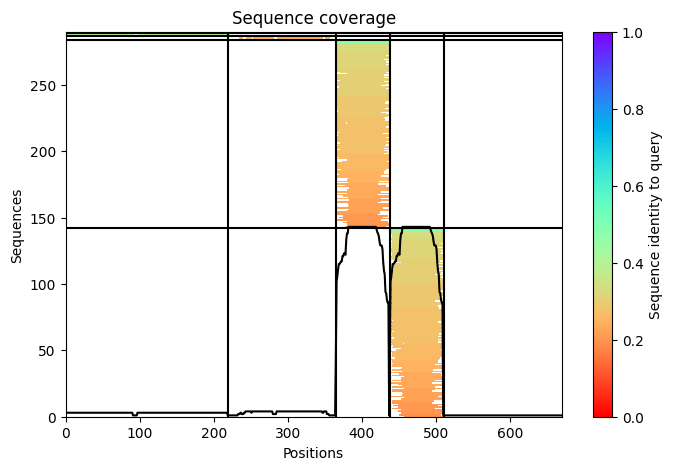

aligning template
Loading alphafold parameters ...


KeyboardInterrupt: 

In [44]:
# -*- coding: utf-8 -*-
"""predict_batch.py

This version runs AlphaFold predictions in **batch** for 20 different sequences.
It is adapted minimally from your original `predict.ipynb` so each job uses:
   - Three 'QIV...' chains
   - Plus one target sequence from the 20
   - A matching template in ./templates/<jobname>.pdb

Simply run this script (e.g. in Colab or a local environment with the appropriate
dependencies) and it will generate 20 folders/results.

--------------------------------------------------------------------------------
"""

import os, time, gc
import re, tempfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from google.colab import files

# IMPORTS from your original script (colabdesign, etc.)
# Make sure these are all installed and available in your environment
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap
import colabdesign.af.contrib.extended_ptm as extended_ptm
from colabdesign.shared.protein import _np_rmsd, _np_kabsch

import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2

#--------------------------------------------------------------------------------
# BATCH INPUTS: 3-chains repeated + 1 target sequence (from your 20).
#--------------------------------------------------------------------------------

# These are your "3 repeated QIV..." chains (as a single multi-chain string).
# If you ever need to modify them, just change them here.
three_chains = (
  "QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ"
  ":QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ"
  ":QIVGTANTQGNRQSPSAPERYNSHGFSLTLTQSIFTLDGTATYTRAASNASAAGAQSSLAQSGQLSATWNLFQ"
)

# Here are the 20 (jobname, target-sequence) pairs you provided.
# For each pair, 'jobname' is what will name the output folder + template path.
# 'seq' is the new chain sequence to be appended after three_chains.
my_batch = [
  ("Cluster10trimerloopsplusbeta_filter_l151_s510177",
   "MGWAELMARYLALPPEEGLRALLADVGGQVEVVLAAVRRLIKLKGESPSLRAQEAFAEDFLASAEAAFEAILAGEPGASSRLYIRMQQLIELAQYLWYLVSKEFPEETELQARLAATVGELQVLTQVFGELAARARLAAAARTDPEAARRL"),
  ("Cluster10trimerloopsplusbeta_filter_l131_s796728",
   "SPAEEEKKKFFENLDIILSLTEENIDEVDMEELWEKLNFVLYYTYKIMAMHAREMTPEQGRELYLLYQVASENLLWAWHAIQALREGRISREEALAVLAKALAAVKEFIRAVAEMGFEPELKEHVEKYFGA"),
  ("Cluster10trimerloopsplusbeta_filter_l159_s806527",
   "MTEEQKKALEYAISYLLGYLPWFPKVEKVFMERLKKEYGINSWEEYKEFILNSEDPELILEVTLDNFVDAAIETGEVRPPLFYQWLEQVLPYYFYAFRSFGEEVLQKVLDRFVAAWERYMRWMAEHRPDLLSPEQAEASIRDYRVWARMQMPNDPSSLP"),
  ("Cluster10trimerloopsplusbeta_filter_l154_s701887",
   "SYAERLAEIEALPLPDIPEVRRMVREMVRVLRRAIAYMEAYPAERGLTDAAAAEIVRAFADAVLESARALVESLPELVAQHEATGRPMTELVMAAFYARRRALEARLYELSRAFQARYPSPEYRQFIHLLFDVIRETEEWLVYILWEGAKRIDE"),
  ("Cluster10trimerloopsplusbeta_filter_l149_s557213",
   "MPNRDDIAQLMYWVQQIAEFVWYLRKWVERHGMEAEFRPVLDELIQIAKDAYQKIYDNYKNFDSLDEEEQVKAVEESVEIAEELAARTRELLARLDALFEEWLARHGADIPHPWDLEYLRGHWAGMRARLEELLAQLEAAVKRIREKLE"),
  ("Cluster10trimerloopsplusbeta_filter_l141_s804125",
   "SEEAERFRELLERARTLVERLVADPATADAAALRAVYEALKALRDWWEGWLAAPPGLPPEDLAEASRPGAYLHMMLQPVGELAYQAEYHEAQLRAQGVAQADIDAAMAGFRAYAAMQMRQVLVYLDLVDEEMARLLARAAA"),
  ("Cluster10trimerloopsplusbeta_filter_l135_s458838",
   "SEVLERNVKEVIEELEELIEVHQRVLEAVERYHPEQAWLARQIQGVINMIRYTQSYFEKGDYEHAISWARAFVHYERQLLLDDLQYYPGELGEHYSRLYYAMRLLPEEEREKIREELAKVVERLEEVVERVVSGE"),
  ("Cluster10trimerloopsplusbeta_filter_l143_s572340",
   "PWWYLPDVPTTAAGLAAEVRGLAERLRAWAARTGLDFDLSPFVRTLELLAESIELVDKAGTDPEAFKKAAEEVEKYNKEIVANYNQMEALGAPSWVRWLVYQIAGAVGQAVYWVKKGYDPARVRNQFLYDIQLVVNYFRQLLA"),
  ("Cluster10trimerloopsplusbeta_filter_l139_s516371",
   "SRFLRRLAEVLERARAEPERGEEILAEAAPELRRLFQEDMTAAYRAHYGPERELVVTHMWIVARVDGRTYVWAENPAVREWLSHFRLPDDSVWLEVVMNGAFYGYYLQFDRAADTVTVYVMWIGWWGHWTTHAETVPLS"),
  ("Cluster10trimerloopsplusbeta_filter_l138_s551808",
   "MLSREEIREEVERGKVLTSWMATQAYAYSQRAIWTGDSDYWTRYGDAQQAEAVGYALTDVAARAVEEEIEDVAEMVERLEERIAEIESYGFRGYYLDILRAALERMKELESIEDALEVLIESFWEVVKLLDRSLWWDM"),
  ("Cluster10trimerloopsplusbeta_filter_l153_s797551",
   "MSEKEKAWQADFKGMARRIVAAFAPVREALAAGTFFRDEGITAFFRALETLRELFAEAAEKYGFPEIGEMVKQLDNLIRSLLWLDFHMHGTQAWHDAMYLAAQAFLRFVDLLEAWTSGEVPTPEELAAAFAEVYAAMSQPVGWAMFNYKRQNT"),
  ("Cluster10trimerloopsplusbeta_filter_l141_s387203",
   "MKSLGEIFAEAIPSLSDKEFWAQINKYLQYYLDQIKGVLAYHKAHPGKYLWPGVIYNYLGYAYGQFRLLVEEAAKRVKHPEILELYEKLKTPPNFYDATVYKKGYEILETWAKFVEARNAGKPEFKEYLEKLIKLVNSLHE"),
  ("Cluster10trimerloopsplusbeta_filter_l142_s202667",
   "APAPLSPEERAVAAAYEFLAAAALPVLDRLEEAVILAIDELIYWTGWSGWPYSAGAAILAALDEVRARLAARPRTRAELEALLAALRAALALARDFAINMDWLAVQLNRPSVGVARLVAVVKEAEAVLAAIEAHVEEALAAA"),
  ("Cluster10trimerloopsplusbeta_filter_l148_s217584",
   "PDPATLAQMIAYWNGIFEPFKEKVIKEGWEGVKETAPVILNEFVDVVYWEFHNHGPEHGFQAQNIAAYYANQALKEIESLDPANHPDVPENELVIKALEKLKAGFTAAYGHAMFYGHYQGLTGWTHTLYAAYEVFVPTLEEVIEYFKK"),
  ("Cluster10trimerloopsplusbeta_filter_l159_s350226",
   "APSMLERLEAQIGIPYEELSPEMQEIWEVVEEMFAVMEADYASWDEQYAAMQGVLAKAEEVSKRLKDPVIYAFFRYLIAVYFSHWGNTDLVVEMVVLWLKFYLNPEKRKTAADYEALIKQMAQLDYVARGGGWNPDWNVMRTLSVMEYEIYQAIKEMAK"),
  ("Cluster10trimerloopsplusbeta_filter_l140_s75369",
   "VDAELAELMAELKAVIAKGGDFAAFRATLERLKSFLIENASKVSPEQIREFSRLLIVYAYGTSQFWHGMAEYAILKMKEVVEAYMKARGIKESDPVYKEVKAELDTWQVIATWSPRINYYDMQYMLEKIDEILEKIEKAK"),
  ("Cluster10trimerloopsplusbeta_filter_l152_s404540",
   "AFEELKRKAEPLARAFEEELRREFAEVRAAVEALLADPALTLEEFYSPVSRLLTDFLTRHVYAVGRAMQSEDPVMQVLAVLMMEVYKAFHEEVTAFLAEVEARALARFGADPRAARHIRYHLGGLHYRHDYWAMSLEHNAKKVEAKVKELEK"),
  ("Cluster10trimerloopsplusbeta_filter_l149_s926572",
   "SLLDELIEEATLLQWYFTGESATWAGSQTWRDVADAIAYLTYLVTEAIRERGADARFSPELIAELRRVMDSLEVIASYYGVFDAVKAGKPLEEIEATATSEGQRRWYRVLYLFSQFILEVRPRLEELTLGEVAEKLLRVMRESVAAMKA"),
  ("Cluster10trimerloopsplusbeta_filter_l143_s732612",
   "MLSPAAQKIEEILRRYFGDDPLAGYAHVVAQGLSLEDFLKEAAEELEELIKTIKEMPGELSERIKNVIKGAENLVEWLKTYREKNPEHSDGQWLHYALRALAEVLFYLAYALWEQYGTEEERALAARAHIARMALAAQSDWNS"),
  ("Cluster10trimerloopsplusbeta_filter_l139_s208901",
   "SMAEKILALFEFLRDVADRLEAGTISVDELVEEFEAFVREHELTYYEVYAYFMQGKAIHEALGLSDEEFLAWLDEQRDRAAALAALLYELVRELSERARTGSAADERKAQLVQMLFDIAQQANYGAYYARQRLEAELAA")
]

#--------------------------------------------------------------------------------
# MAIN LOOP – minimal additions to do each sequence + its template
#--------------------------------------------------------------------------------

for (jobname, new_seq) in my_batch:
  print("=======================================================")
  print(f"Processing jobname: {jobname}")
  print("=======================================================")

  # 1) Combine your 3 'QIV...' chains with the new sequence
  sequence = three_chains + ":" + new_seq
  print(sequence)
  # 2) Template setup with logging
  template_mode = "custom"
  pdb = f"./templates/{jobname}.pdb"
  chain = "A,B"

  # Log template info to both console and a file
  print(f"\nTemplate information:")
  print(f"- Template mode: {template_mode}")
  print(f"- Template path: {pdb}")
  print(f"- Template chains: {chain}")

  # Create log directory if it doesn't exist
  os.makedirs("template_logs", exist_ok=True)
  with open("template_logs/template_usage.log", "a") as f:
    f.write(f"\n{'='*50}\n")
    f.write(f"Job: {jobname}\n")
    f.write(f"Template mode: {template_mode}\n")
    f.write(f"Template path: {pdb}\n")
    f.write(f"Template chains: {chain}\n")
    # Add template file existence check
    if os.path.exists(pdb):
      f.write(f"Template file exists: Yes\n")
      template_size = os.path.getsize(pdb)
      f.write(f"Template file size: {template_size/1024:.2f} KB\n")
    else:
      f.write(f"Template file exists: No - WARNING\n")
    f.write(f"{'='*50}\n")

  # 3) Everything else is basically your original script, except
  #    we override jobname, template_mode, pdb, chain, and sequence.
  #    (See below for small tweaks so each job is in a separate folder.)

  ###################################################################
  # from your original 'predict.ipynb' code – with minimal changes
  ###################################################################
  import re, tempfile
  from IPython.display import HTML
  from google.colab import files
  import numpy as np
  import matplotlib.pyplot as plt
  import string
  import numpy as np

  def run_hhfilter(input, output, id=90, qid=10):
    os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

  @jax.jit
  def get_coevolution(X):
    '''given one-hot encoded MSA, return contacts'''
    Y = jax.nn.one_hot(X,22)
    N,L,A = Y.shape
    Y_flat = Y.reshape(N,-1)
    # covariance
    c = jnp.cov(Y_flat.T)

    # inverse covariance
    shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
    ic = jnp.linalg.inv(c + shrink)

    # partial correlation coefficient
    ic_diag = jnp.diag(ic)
    pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

    raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
    i = jnp.arange(L)
    raw = raw.at[i,i].set(0)
    # do apc
    ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
    return (raw - ap).at[i,i].set(0)

  def plot_3D(aux, Ls, file_name, show=False):
    from colabdesign.shared.protein import _np_kabsch
    xyz = aux["atom_positions"][:,1]
    xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    if len(Ls) > 1:
      plt.title("chain")
      c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
      plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
    else:
      plt.title("length")
      plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
    plt.axis(False)
    ax = plt.subplot(1,2,2)
    plt.title("plddt")
    plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
    plt.axis(False)
    plt.savefig(file_name, dpi=200, bbox_inches='tight')
    plt.show() if show else plt.close()

  def run_do_not_align(query_sequence, target_sequence, **arg):
    return [query_sequence,target_sequence],[0,0]

  def get_pdb(pdb_code=""):
    if pdb_code is None or pdb_code == "":
      upload_dict = files.upload()
      pdb_string = upload_dict[list(upload_dict.keys())[0]]
      with open("tmp.pdb","wb") as out: out.write(pdb_string)
      return "tmp.pdb"
    elif os.path.isfile(pdb_code):
      return pdb_code
    elif len(pdb_code) == 4:
      os.makedirs("tmp",exist_ok=True)
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
      return f"tmp/{pdb_code}.cif"
    else:
      os.makedirs("tmp",exist_ok=True)
      os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
      return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

  # --------------------------------------------------
  # Basic inputs we want to hold fixed for each job
  # (besides sequence/jobname/pdb/chain)
  # --------------------------------------------------
  copies = 1
  msa_method = "mmseqs2"
  pair_mode = "unpaired_paired"
  cov = 75
  id = 90
  qid = 0
  do_not_filter = False

  rm_sidechain = False
  rm_sequence = False
  rm_template_seq = False

  # Only keep alphanumeric for jobname folder
  jobname = re.sub(r'\W+', '', jobname)

  from colabdesign.af.contrib import predict

  # (NEW) Keep the raw list from `sequence.split(":")`
  u_sequences = sequences  # keep duplicates as-is

  # If you need to handle cyclic or slash '/' notation, do that next:
  u_cyclic = [x.startswith("(") for x in u_sequences]
  u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]

  # Remove parentheses or slashes from each chain sequence
  u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]

  # Now the lengths, and the combined 'seq'
  u_lengths = [len(x) for x in u_sequences]
  sub_seq = "".join(u_sequences)
  seq = sub_seq * copies

  print("u_sequences:", u_sequences)
  print("u_lengths:", u_lengths)
  print("seq length:", len(seq))

  # Slightly disambiguate the jobname if folder already exists
  def _check(folder): return os.path.exists(folder)
  base_jobname = jobname + "_" + predict.get_hash(seq)[:5]
  jobname = base_jobname
  idx = 0
  while _check(jobname):
    idx += 1
    jobname = f"{base_jobname}_{idx}"

  print("jobname", jobname)
  print(f"length={u_lengths} copies={copies}")

  input_opts = {
    "sequence":u_sequences,
    "copies":copies,
    "msa_method":msa_method,
    "pair_mode":pair_mode,
    "do_not_filter":do_not_filter,
    "cov":cov,
    "id":id,
    "template_mode":template_mode,
    "propagate_to_copies":True
  }

  def run_mmseqs2_wrapper(*args, **kwargs):
    kwargs['user_agent'] = "colabdesign/gamma"
    return run_mmseqs2(*args, **kwargs)

  # Prepare MSA
  os.makedirs(jobname, exist_ok=True)

  Ls = [len(x) for x in u_sequences]
  if msa_method == "mmseqs2":
    msa, deletion_matrix = predict.get_msa(
      u_sequences, jobname,
      mode=pair_mode,
      cov=cov, id=id, qid=qid, max_msa=4096,
      do_not_filter=do_not_filter,
      mmseqs2_fn=run_mmseqs2_wrapper,
      hhfilter_fn=run_hhfilter
    )
  else:
    raise ValueError("In this minimal example, only mmseqs2 is shown.")

  if len(msa) > 1:
    predict.plot_msa(msa, Ls)
    plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
    plt.show()

  # If use_templates => "custom" or "mmseqs2"
  use_templates = (template_mode in ["mmseqs2","custom"])
  if use_templates:
    print("aligning template")
    template_msa = f"{jobname}/msa.a3m"  # default
    # We'll do "custom" with your local PDB, skip alignment
    # (just do run_do_not_align)
    if template_mode == "custom":
      pdbs = [[pdb]]
      chains = [[chain]]
    else:
      raise ValueError("In this minimal batch script, only template_mode='custom' is used.")

  # We'll load the model (reused across runs if you want, but for clarity we do inside the loop)
  from colabdesign import mk_af_model

  # minimal model configs
  model_type = "auto"
  if len(u_lengths) > 1 or copies > 1:
    use_multimer = True
    pseudo_multimer = False
    rank_by = "multi"
  else:
    use_multimer = False
    pseudo_multimer = False
    rank_by = "plddt"

  # Build the AF model
  model_opts = {
    "num_msa":512,
    "num_extra_msa":1024,
    "num_templates":len(pdbs),
    "use_cluster_profile":True,
    "use_multimer":use_multimer,
    "pseudo_multimer":pseudo_multimer,
    "use_templates":use_templates,
    "use_batch_as_template":False,
    "use_dgram":True,
    "protocol":"hallucination",
    "best_metric":rank_by,
    "optimize_seq":False,
    "debug":False,
    "clear_prev":False
  }
  # load parameters
  print("Loading alphafold parameters ...")
  clear_mem()
  af = mk_af_model(use_mlm=True, **model_opts)

  # prep AF input
  af.prep_inputs(u_lengths, copies=copies, seed=0)
  print_key = ["plddt","ptm"]
  if len(af._lengths) > 1: print_key += ["i_ptm","multi"]

  # Setup template (if any)
  if use_templates:
      af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"], True)
      af.set_opt(use_initial_guess=False)

      # "batches" => We'll store them in "all_template_batches"
      all_template_batches = []
      for pdb_list, chain_list in zip(pdbs, chains):
        query_seq = "".join(u_sequences)
        batch = predict.get_template_feats(
            pdb_list, chain_list,
            query_seq=query_seq,
            query_a3m=f"{jobname}/msa.a3m",  # or "msa_tmp.a3m"
            copies=copies,
            propagate_to_copies=True,
            use_seq=not rm_sequence,
            get_pdb_fn=get_pdb,
            align_fn=run_do_not_align
        )
        all_template_batches.append(batch)

      # incorporate each batch
      for i, tmpl_batch in enumerate(all_template_batches):
        af.set_template(batch=tmpl_batch, n=i)
      af.set_opt("template", rm_sc=rm_sidechain, rm_seq=rm_sequence)

      # ---------------------------------------------
      # for display of template distance gram features
      # ---------------------------------------------
      if len(all_template_batches) > 0:
        plt.figure(figsize=(3*len(all_template_batches), 3))
        for n, tmpl_batch in enumerate(all_template_batches):
          plt.subplot(1, len(all_template_batches), n + 1)
          plt.title(f"template features {n+1}")
          # 'dgram' is shape [N_res, N_res, bins], so we take argmax over last dim
          dgram = tmpl_batch["dgram"].argmax(-1).astype(float)
          # zero out positions in which 'dgram' sum = 0
          dgram[tmpl_batch["dgram"].sum(-1) == 0] = np.nan
          Ln = dgram.shape[0]
          plt.imshow(dgram, extent=(0, Ln, Ln, 0))
          predict.plot_ticks(Ls * copies)  # add chain ticks
        plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
        plt.show()
  else:
      all_template_batches = [None]

  # set MSA
  af.set_msa(msa, deletion_matrix)

  # handle chainbreaks
  L_prev = 0
  for n,l in enumerate(u_sub_lengths * copies):
    for L_i in l[:-1]:
      af._inputs["residue_index"][L_prev+L_i:] += 32
      L_prev += L_i
    L_prev += l[-1]

  # set cyclic constraints, if any
  i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
  if len(i_cyclic) > 0:
    add_cyclic_offset(af,i_cyclic)

  #########################
  # Run the actual predictions
  #########################
  from colabdesign.af.contrib.extended_ptm import get_chain_and_interface_metrics
  import sys

  model = "all"
  num_recycles = 12
  recycle_early_stop_tolerance = 0.0
  select_best_across_recycles = False
  use_mlm = True
  use_dropout = False
  seed0 = 0
  num_seeds = 1

  run_opts = {
    "seed":seed0,
    "use_mlm":use_mlm,
    "use_dropout":use_dropout,
    "num_recycles":num_recycles,
    "model":model,
    "use_initial_guess":False,
    "select_best_across_recycles":select_best_across_recycles,
    "recycle_early_stop_tolerance":recycle_early_stop_tolerance
  }

  af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

  # folder for PDB results
  pdb_path = f"{jobname}/pdb"
  os.makedirs(pdb_path, exist_ok=True)

  info = []
  af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
             "log":[],"best":{}}

  print("Running prediction ...")
  with open(f"{jobname}/log.txt","w") as handle:
    seeds = list(range(seed0,seed0+num_seeds))
    all_models = af._model_names if model == "all" else [af._model_names[int(model)-1]]

    for this_seed in seeds:
      af.set_seed(this_seed)
      for mod_name in all_models:
        recycle = 0
        af._inputs.pop("prev",None)
        stop_recycle = False
        prev_pos = None
        while recycle < num_recycles + 1:
          print_str = f"seed={this_seed} model={mod_name} recycle={recycle}"
          af.predict(dropout=use_dropout, models=[mod_name], verbose=False)
          af._inputs["prev"] = af.aux["prev"]

          # save results
          if len(af._lengths) > 1:
            af.aux["log"]["multi"] = 0.8*af.aux["log"]["i_ptm"] + 0.2*af.aux["log"]["ptm"]

          out_pdb = f"{pdb_path}/{mod_name}_r{recycle}_seed{this_seed}.pdb"
          af.save_current_pdb(out_pdb)

          # print metrics
          for k in print_key:
            print_str += f" {k}={af.aux['log'][k]:.3f}"

          current_pos = af.aux["atom_positions"][:,1]
          if recycle>0:
            rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
            print_str += f" rmsd_tol={rmsd_tol:.3f}"
            if rmsd_tol < recycle_early_stop_tolerance:
              stop_recycle = True
          prev_pos = current_pos

          print(print_str); handle.write(print_str+"\n")

          tag = f"{mod_name}_r{recycle}_seed{this_seed}"
          if select_best_across_recycles:
            info.append([tag,print_str,af.aux["log"][rank_by]])
            af._save_results(save_best=True,
                             best_metric=rank_by, metric_higher_better=True,
                             verbose=False)
            af._k += 1
          else:
            if recycle == num_recycles:
              info.append([tag,print_str,af.aux["log"][rank_by]])
              af._save_results(save_best=True,
                               best_metric=rank_by, metric_higher_better=True,
                               verbose=False)
              af._k += 1

          recycle += 1
          if stop_recycle: break

        # finalize + save images
        plot_3D(af.aux, Ls*copies, f"{pdb_path}/{mod_name}_seed{this_seed}.pdf", show=False)
        predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls*copies)
        plt.savefig(f"{pdb_path}/{mod_name}_seed{this_seed}.png", dpi=200, bbox_inches='tight')
        plt.close()

  # Save best results
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  print(f"best_tag={info[rank[0]][0]} => {info[rank[0]][1]}")

  aux_best = af._tmp["best"]["aux"]
  af.save_pdb(f"{pdb_path}/best.pdb")
  np.savez_compressed(f"{pdb_path}/best.npz",
                      plddt=aux_best["plddt"].astype(np.float16),
                      pae=aux_best["pae"].astype(np.float16),
                      tag=np.array(info[rank[0]][0]),
                      metrics=np.array(info[rank[0]][1]))
  np.savez_compressed(f"{pdb_path}/all.npz",
                      plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                      pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                      tag=np.array([x[0] for x in info]),
                      metrics=np.array([x[1] for x in info]))

  plot_3D(aux_best, Ls*copies, f"{pdb_path}/best.pdf", show=False)
  predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls*copies)
  plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
  plt.close()

  # Add settings file
  with open(f"{jobname}/settings.txt", "w") as text_file:
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")

  # Optionally ZIP each job result. (Comment out if not needed.)
  os.system(f"zip -r {jobname}.zip {jobname}")

  print("GC", gc.collect())

# END of for-loop over all 20 sequences
print("All 20 sequences processed. Check each <jobname>/ folder for outputs.")


#FAQ
How is this notebook different from ColabFold?
- Assuming same settings, the results should be the same. The purpose of the notebook is to add more advanced options and give people more control on the python level.

How to specify chainbreaks?
- `sequence` Specify protein sequence to be modelled.
  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.

How to specify cyclic constraints?
- When entering sequence use `()` to specify which parts should be cyclic. For example: `ABC:(DEF):GHI`, the second protein will be cyclicalized.

**Extra options**
- `select_best_across_recycles` - select best model across all recycles.

I want to access all the raw outputs, how do I do this?
- Set: `debug`=`True`. After run_alphafold, you can access all outputs via `best_aux["debug"]["outputs"]`.

**Template options**

How to provide inter-chain templates?
- Set: template_mode=`custom`, pdb=`1abc`, chain=`A,B`
- for homo-oligomeric inputs set: `propagate_to_copies`=`False` otherwise same pdb will be copied to all.

For some reason the interchain template info is not used...
- Try `model_type`=`monomer` or `model_type`=`pseudo_multimer`.

How to provide more than one pdb, one for each sequence in the multimer?
- Set: template_mode=`custom`, pdb=`1abc:2abc`, chain=`A:A`

Can I use this notebook to simulate `af2rank`?
- `rm_template_seq` - removing the template sequence unlocks alpahfold's discriminatory power, see [af2rank](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.238101) for details.
- `use_mlm` (disabled in af2rank) enables random masking of input MSA.

**Currently not supported**
- Mixture of symmetries.
- Amber relax. To relax, use our [relax notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/relax_amber.ipynb).


